# Лабораторная работа 4.1

# Практика TensorFlow 2.x

### Задание

В данной лабораторной работе будет практиковаться материал из лекций по TensorFlow на примере решения задачи классификации изображений из датасета Fashion MNIST. Fashion MNIST - набор черно-белых изображений размера 28х28, что поделены на 10 классов. Будет построена с нуля и обучена модель логистической регрессии используя как низкоуровневый API. Опционально решение той же задачи нейронной сетью, построенной и обученной с использованием Keras.

0 Базовые операции. 
   - 0.1 Сгенерируйте три непересекающихся гауссовых облака, используя `tf.random`. Визуализируйте их разными цветами, используя matplotlib. 
   - 0.2 Сгенерируйте случайную матрицу 2x2, умножьте каждую точку в облаках на эту матрицу. Повторно визуализируйте облака.

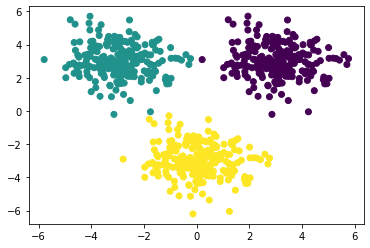

In [40]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
N = 223
noise = tf.random.normal((N, 2), 0, 1)

cloud1 = noise + np.array([3, 3])
cloud2 = noise + np.array([-3, 3])
cloud3 = noise + np.array([0, -3])

data = np.vstack([cloud1, cloud2, cloud3])

annotation1 = [0]*N
annotation2 = [1]*N
annotation3 = [2]*N

annotations = annotation1 + annotation2 + annotation3
plt.scatter(data[:,0], data[:,1], c=annotations)

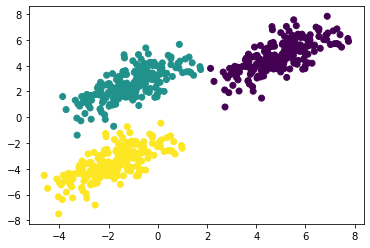

In [41]:
matr = tf.random.uniform((2, 2), 0, 2)

cloud11 = tf.matmul(cloud1, matr)
cloud21 = tf.matmul(cloud2, matr)
cloud31 = tf.matmul(cloud3, matr)

data1 = np.vstack([cloud11, cloud21, cloud31])

plt.scatter(data1[:,0], data1[:,1], c=annotations)

1 Загрузите датасет Fashion MNIST, используя метод из [tf.keras.datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets). Визуализируйте несколько изображений, используя библиотеку matplotlib.

In [45]:
import ssl
import tensorflow as tf
ssl._create_default_https_context = ssl._create_unverified_context
mnist = tf.keras.datasets.fashion_mnist.load_data()

In [46]:
(x_train, y_train), (x_test, y_test) = mnist
print ('Training data shape: ', x_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', x_test.shape)
print ('Test labels shape: ', y_test.shape)
dict_classes = {0:'top', 1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneaker', 8:'bag', 9:'boot'}

Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


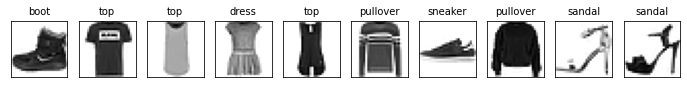

In [48]:
def plot_first_images(img, labels, idx, num):
    pred = []
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    for i in range(0, num):
        ax = plt.subplot(5, 10, 1 + i)
        ax.imshow(img[idx], cmap = 'binary')
        title = dict_classes[labels[i]]
        ax.set_title(title, fontsize = 10)
        ax.set_xticks([]); ax.set_yticks([])
        idx += 1
    plt.show()
plot_first_images (x_train, y_train, 0, 10) 

2 Нормализуйте данные либо средним и СКО, либо приведя значения пикселей в интервал [-1, 1].

In [13]:
x_train = x_train.reshape(60000, -1)
x_test = x_test.reshape(10000, -1)
x_train.shape, x_test.shape
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

mean, std = x_train.mean(axis=0), x_train.std(axis=0)
x_train = (x_train - mean) / (std + 1e-3)
x_test = (x_test - mean) / (std + 1e-3)

3 Создайте обучающий и тестовый TensorFlow Dataset из нормализованного набора данных. К обучающему датасету добавьте перемешивание (`.shuffle`). К обоим датасетам добавьте генерацию батчей размера 128 (`.batch(128)`).

In [24]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_dataset = train_dataset.shuffle(buffer_size=len(x_train), reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(128)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)


4 Напишите класс слоя Flatten, что трансформирует изображения из матричного в векторный вид: [28, 28] -> [28 * 28]. Класс слоя должен наследоваться от tf.Module. Для трансформации тензоров изображений использовать tf.reshape.

In [25]:
class Flatten(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
    def __call__(self, x):
        x_shape = tf.shape(x)
        if len(x_shape) == 1:
            new_shape = x_shape
        elif len(x_shape) == 2:
            new_shape = (1, tf.math.reduce_prod(x_shape))
        else:
            new_shape = (x_shape[0], tf.math.reduce_prod(x_shape[1:]))
        return tf.reshape(x, new_shape)

5 Напишите класс линейного слоя `Linear`, что умножает входной вектор на матрицу весов. Класс слоя должен наследоваться от `tf.Module`. Матрицу весов хранить в `tf.Variable`. Параметры конструктора: `in_d` - размерность входного вектора, `out_d` - размерность выходного вектора. В качестве начальной инициализации весов использовать гауссово распределение с СКО=0.01.

In [26]:
class Linear(tf.Module):
    def __init__(self, in_d, out_d, name=None):
        super().__init__(name=name)
        w = tf.random.normal(shape=[in_d, out_d], stddev=0.01, dtype='float32')
        self.w = tf.Variable(w, name='linear')
        self.b = tf.Variable(tf.zeros(out_d, dtype='float32'), name='bias')
        
    def __call__(self, x):
        return tf.matmul(x, self.w) + self.b

6 Напишите класс модели логистической регрессии `LogisticRegression`, что компонует в себе слои `Linear` и `Flatten`. Класс модели должен наследоваться от `tf.Module`. В качестве функции активации используйте `tf.nn.softmax`.
Создайте объект модели и попробуйте с помощью неё классифицировать одно изображение (не забудьте о размерности батча! Она будет равна 1).

In [27]:
class LogisticRegression(tf.Module):
    def __init__(self, in_d, out_d, name=None):
        super().__init__(name=name)
        linear_name = None
        if name is not None:
            linear_name = name + '_linear'
        self.linear = Linear(in_d, out_d, name=linear_name)
        
    def __call__(self, x):
        x = self.linear(x)
        return tf.nn.softmax(x)

In [28]:
model = LogisticRegression(28*28,10)
preds = model(x_train[0:1])

In [29]:
tf.argmax(preds, axis=1)

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([9], dtype=int64)>

7 Напишите функцию оценки точности модели `evaluate`. Список её аргументов: тестовый tf.Dataset, модель. Данная функция будет отличаться оной из лекций тем, что внутри неё не будет ручной выборки батчей из датасета, поскольку tf.Dataset уже делает это за нас.

In [30]:
def accuracy(y_true, y_pred):
    eq = tf.cast(y_true == y_pred, 'float32')
    return tf.reduce_mean(eq)
    
def evaluate(model, ds):
    y_preds = []
    y_test = []
    for x,y in tqdm(ds):
        preds = model(x)
        preds = tf.argmax(preds, axis=-1)
        y_preds.append(preds)
        y_test.append(y)
    
    y_test = tf.concat(y_test, axis=0)
    y_preds = tf.concat(y_preds, axis=0)
    y_preds = tf.cast(y_preds, 'int32')
    
    return accuracy(y_test, y_preds).numpy()

8 Напишите функцию обучающего шага `train_step`. Данная функция будет немного отличаться от показанной в лекции тем, что ей на вход также дается функция ошибки. Полный список аргументов: модель, тупл данных (батч картинок, батч меток), оптимизатор, функция ошибки. Функция `train_step` должна возвращать вычисленное значение функции ошибки.

В данной лабораторной функция ошибки не будет писаться заново, будет использоваться готовая кросс-энтропия из Keras.

In [31]:
def train_step(model, data, optim, criterion):
    with tf.GradientTape() as tape:
        x, y = data
        preds = model(x)
        loss = criterion(y, preds)
    grads = tape.gradient(loss, model.trainable_variables)
    optim.apply_gradients(zip(grads, model.trainable_variables))
    return loss

9 Оцените точность модели.

In [32]:
acc = evaluate(model, test_dataset)
print('Acuracy', round(acc * 100, 2), '%')

100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 699.12it/s]

Acuracy 9.43 %


10 Подготовьте гиперпараметры обучения: оптимизатор, функция ошибки ([tf.keras.losses.SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)), количество эпох.

In [33]:
epochs = 5
print_period = 100

optim = tf.optimizers.Adam(learning_rate=0.005)
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()

11 Напишите обучающий цикл. Цикл состоит из внешнего цикла, что отсчитывает эпохи, и вложенного, что итерируется по обучающему датасету.
Во вложенном цикле должна вызываться функция `train_step`. Каждую эпоху модель должна тестироваться функцией `evaluate`. Должны выводиться номер эпохи, значение ошибки и точности. Сохраняйте значения ошибки и точности в списки. Обучите модель. По ходу обучения подбирайте более оптимальные гиперпараметры обучения (learning_rate, другой оптимизатор).

In [34]:
loss_data = []
acc_data = []
for epoch in range(epochs):
    cnt = 0
    for x,y in tqdm(train_dataset):

        loss = train_step(model, (x,y), optim, cross_entropy)
        
        if cnt % print_period == 0:
            print('Epoch:', epoch, 'Iteration:', cnt, 'Loss:', loss.numpy())
        loss_data.append(loss.numpy())
        cnt += 1      
    acc = evaluate(model, test_dataset)
    print('Epoch:', epoch, 'Accuracy:', acc)
    acc_data.append(acc)

  6%|████▌                                                                           | 27/469 [00:00<00:03, 116.54it/s]

Epoch: 0 Iteration: 0 Loss: 2.3372412


 30%|███████████████████████▍                                                       | 139/469 [00:00<00:01, 203.21it/s]

Epoch: 0 Iteration: 100 Loss: 0.44985598


 48%|██████████████████████████████████████▏                                        | 227/469 [00:01<00:01, 210.18it/s]

Epoch: 0 Iteration: 200 Loss: 0.4719184


 72%|████████████████████████████████████████████████████████▊                      | 337/469 [00:01<00:00, 212.05it/s]

Epoch: 0 Iteration: 300 Loss: 0.4983322


 91%|███████████████████████████████████████████████████████████████████████▌       | 425/469 [00:02<00:00, 211.11it/s]

Epoch: 0 Iteration: 400 Loss: 0.47165596


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1161.76it/s]


Epoch: 0 Accuracy: 0.8168


  0%|▏                                                                                 | 1/469 [00:00<01:04,  7.30it/s]

Epoch: 1 Iteration: 0 Loss: 0.42780003


 28%|█████████████████████▋                                                         | 129/469 [00:00<00:01, 230.95it/s]

Epoch: 1 Iteration: 100 Loss: 0.4473418


 49%|███████████████████████████████████████                                        | 232/469 [00:01<00:00, 249.92it/s]

Epoch: 1 Iteration: 200 Loss: 0.37041682


 72%|████████████████████████████████████████████████████████▊                      | 337/469 [00:01<00:00, 254.97it/s]

Epoch: 1 Iteration: 300 Loss: 0.43672788


 94%|██████████████████████████████████████████████████████████████████████████▍    | 442/469 [00:01<00:00, 255.10it/s]

Epoch: 1 Iteration: 400 Loss: 0.55449057


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1316.65it/s]


Epoch: 1 Accuracy: 0.8073


  0%|▏                                                                                 | 1/469 [00:00<01:05,  7.19it/s]

Epoch: 2 Iteration: 0 Loss: 0.36447382


 33%|██████████████████████████▎                                                    | 156/469 [00:00<00:01, 242.25it/s]

Epoch: 2 Iteration: 100 Loss: 0.41374978


 49%|███████████████████████████████████████                                        | 232/469 [00:01<00:00, 246.77it/s]

Epoch: 2 Iteration: 200 Loss: 0.5009461


 72%|████████████████████████████████████████████████████████▌                      | 336/469 [00:01<00:00, 254.17it/s]

Epoch: 2 Iteration: 300 Loss: 0.82794416


 94%|██████████████████████████████████████████████████████████████████████████     | 440/469 [00:01<00:00, 253.96it/s]

Epoch: 2 Iteration: 400 Loss: 0.41671693


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1274.26it/s]


Epoch: 2 Accuracy: 0.8208


  0%|▏                                                                                 | 1/469 [00:00<01:05,  7.09it/s]

Epoch: 3 Iteration: 0 Loss: 0.39700228


 28%|█████████████████████▉                                                         | 130/469 [00:00<00:01, 231.81it/s]

Epoch: 3 Iteration: 100 Loss: 0.49456874


 49%|███████████████████████████████████████                                        | 232/469 [00:01<00:00, 248.52it/s]

Epoch: 3 Iteration: 200 Loss: 0.4695747


 72%|████████████████████████████████████████████████████████▌                      | 336/469 [00:01<00:00, 251.74it/s]

Epoch: 3 Iteration: 300 Loss: 0.47624683


 94%|██████████████████████████████████████████████████████████████████████████▎    | 441/469 [00:01<00:00, 255.27it/s]

Epoch: 3 Iteration: 400 Loss: 0.49311528


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1274.21it/s]


Epoch: 3 Accuracy: 0.8278


  0%|▏                                                                                 | 1/469 [00:00<01:03,  7.35it/s]

Epoch: 4 Iteration: 0 Loss: 0.37433827


 28%|██████████████████████▏                                                        | 132/469 [00:00<00:01, 237.72it/s]

Epoch: 4 Iteration: 100 Loss: 0.47011375


 51%|███████████████████████████████████████▉                                       | 237/469 [00:01<00:00, 254.26it/s]

Epoch: 4 Iteration: 200 Loss: 0.35880718


 73%|█████████████████████████████████████████████████████████▌                     | 342/469 [00:01<00:00, 258.18it/s]

Epoch: 4 Iteration: 300 Loss: 0.49709564


 95%|███████████████████████████████████████████████████████████████████████████▏   | 446/469 [00:01<00:00, 256.71it/s]

Epoch: 4 Iteration: 400 Loss: 0.8023077


100%|████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 1316.70it/s]

Epoch: 4 Accuracy: 0.81


12 Выведите графики точности и ошибки, используя matplotlib.

In [35]:
v_1 = np.arange(0, len(loss_data), 1)
v_2 = np.arange(0, len(acc_data), 1)
print(len(v_1))
print(len(v_2))

2345
5


13 (Опционально) Постройте и обучите произвольную нейронную сеть с использованием Keras для решения той же задачи. 